In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy import interpolate
import h5py
import pickle
import constants as cst

import sys
import os
import subprocess
from copy import copy
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

import Reading_Scripts as Reading
import kgrid as kgrid
import Photo_Emission as Photo
import Incoherent_Photo_Emission as Incoherent


np.set_printoptions(threshold=np.inf)

In [2]:
system="BlackP"
out_path = "./../../OUT/"
path = "../../DATA/data_excitons/"+system+"/"

In [3]:
nkx=72
nky=72
nkz=72

nk_interp = 170

x1 = np.linspace(-0.5,0.5, nkx+1)[0:-1]
x1_interp = np.linspace(-0.5,0.5, nk_interp+1)[0:-1]

fname = path + "BlackP_grid_nk"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_wann_calc.h5"
Energies = Reading.ReadBands(fname)
Energie_no_Valence  = Energies[:,18]
Energie_Valence     = Energies[:,19]
Energie_Conduction  = Energies[:,20]

##estos archivos se deben mover a la carpeta de outputs al final del dia
fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc.h5"
ϵ,ϕ_real,ϕ_imag =Reading.Read_Eigen_states(fname)

fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc_dens.h5"
ψ = Reading.Read_Density(fname)

In [4]:
def paramters(direccion,Q_plots):
    Σy      = np.zeros((3,len(Q_plots)))  
    X0y     = np.zeros((3,len(Q_plots)))  
    X_max_y = np.zeros((3,len(Q_plots)))
    Y_max_y = np.zeros((3,len(Q_plots)))

    Ay      = np.zeros((3,len(Q_plots)))  
    Cy      = np.zeros((3,len(Q_plots)))  
    
    energia_exciton = np.zeros((len(Q_plots)))
    for ii_q in range(len(Q_plots)):
        if direccion == 'kx':
            QQ = np.array([Q_plots[ii_q],0.0,0.0])
        if direccion == 'ky':
            QQ = np.array([0.0,Q_plots[ii_q],0.0])
        if direccion == 'kz':
            QQ = np.array([0.0,0.0,Q_plots[ii_q]])

        if np.sign(Q_plots[ii_q]) <  0.0:
            path_excitons = "out_Hqpgw_minus_new_merlin"
        if np.sign(Q_plots[ii_q]) >  0.0:
            path_excitons = "out_Hqpgw_plus_new_merlin"
        if np.sign(Q_plots[ii_q]) == 0.0:
            path_excitons = "out_Hqpgw_new"

        ϵ_plus,ψ_plus = Incoherent.Reading_Data(QQ,path_excitons,retorno=5)
        pos_fix = np.where( np.reshape(ψ_plus[0,:], [nkx,nky,nkz]) ==np.max (np.reshape(ψ_plus[0,:], [nkx,nky,nkz])) )

        poptx_plus,popty_plus,poptz_plus = Incoherent.Fitting_Parameters(x1,nkx,nky,nkz,ψ_plus,direccion,-Q_plots[ii_q],pos_fix)

        Σy[:,ii_q] =  abs(np.array([poptx_plus[1],popty_plus[1],poptz_plus[1]]))
        X0y[:,ii_q] =  np.array([poptx_plus[2],popty_plus[2],poptz_plus[2]])

        xmax_p,ymax_p = Incoherent.maximos(x1,np.reshape(ψ_plus[0,:] , [nkx,nky,nkz])[:,pos_fix[1][0],pos_fix[2][0]])
        xmay_p,ymay_p = Incoherent.maximos(x1,np.reshape(ψ_plus[0,:] , [nkx,nky,nkz])[pos_fix[0][0],:,pos_fix[2][0]])
        xmaz_p,ymaz_p = Incoherent.maximos(x1,np.reshape(ψ_plus[0,:] , [nkx,nky,nkz])[pos_fix[0][0],pos_fix[1][0],:])

        X_max_y[:,ii_q] =  np.array([xmax_p,xmay_p,xmaz_p])
        Y_max_y[:,ii_q] =  np.array([ymax_p,ymay_p,ymaz_p])
        
        energia_exciton[ii_q] = ϵ_plus[0]


    Ay = ( -X0y  + X_max_y) / ( X0y * X_max_y - X_max_y**2 +  Σy )        
    Cy =  Y_max_y/( ( 1+Ay * X_max_y ) * np.exp( -(X_max_y - X0y )**2/(2*Σy**2) ) )
    
    return Cy,Σy,X0y,Ay,X_max_y,Y_max_y,energia_exciton


#Q_grid =[0.0278,0.0556,0.1112,0.2224]
Q_grid =[0.0278,0.0556]
Q_plots = np.sort(list([0.0])+list(Q_grid)+list(-np.array(Q_grid)))

direccion = 'kx'
Cx,Σx,X0x,Ax,X_max_x,Y_max_x,ϵ_x = paramters(direccion,Q_plots)

direccion = 'ky'
Cy,Σy,X0y,Ay,X_max_y,Y_max_y,ϵ_y = paramters(direccion,Q_plots)

direccion = 'kz'
Cz,Σz,X0z,Az,X_max_z,Y_max_z,ϵ_z = paramters(direccion,Q_plots)

fx,fy,fz,ft = Incoherent.interpolador(direccion)

0.018358505535969204 0.018581012289377044 0.01825380467100091


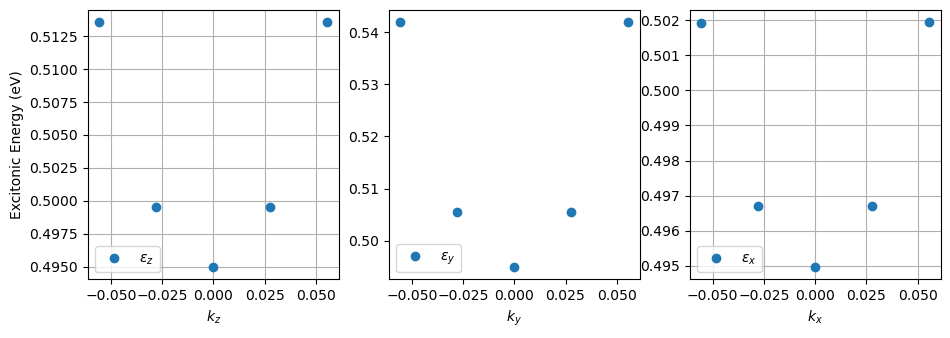

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3.5))
ax1.plot(Q_plots,ϵ_x*cst.Ry,'o',label=r'$\epsilon_z$')
ax1.set_xlabel(r'$k_z$')
ax1.set_ylabel('Excitonic Energy (eV)')
ax1.legend()
#ax1.set_ylim(0.01818,0.0189)
ax1.grid()
ax2.plot(Q_plots,ϵ_y*cst.Ry,'o',label=r'$\epsilon_y$')
ax2.set_xlabel(r'$k_y$')
ax2.legend()
#ax2.set_ylim(0.01818,0.02)
ax3.plot(Q_plots,ϵ_z*cst.Ry,'o',label=r'$\epsilon_x$')
ax3.set_xlabel(r'$k_x$')
ax3.legend()
#ax3.set_ylim(0.01818,0.0185)
ax3.grid()
print(ϵ_x[3],ϵ_y[3],ϵ_z[3])

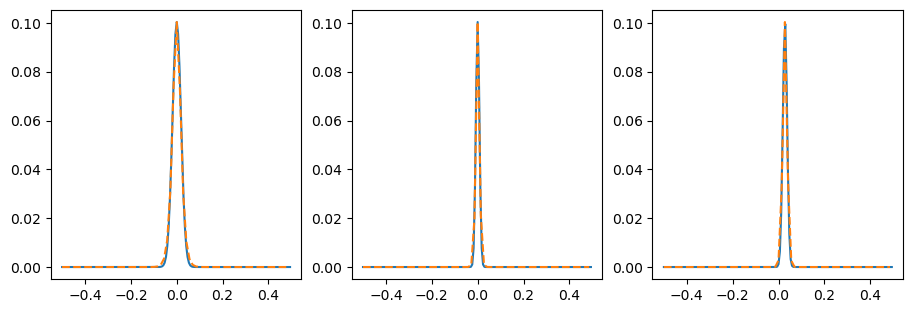

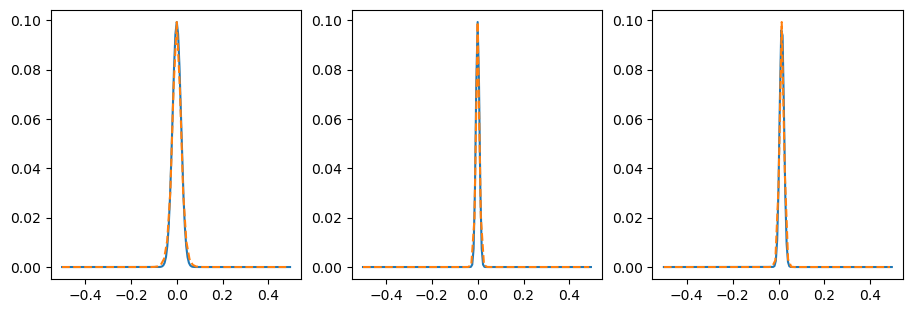

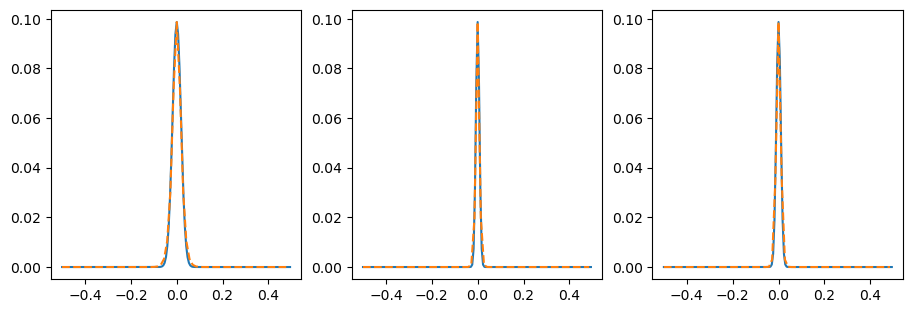

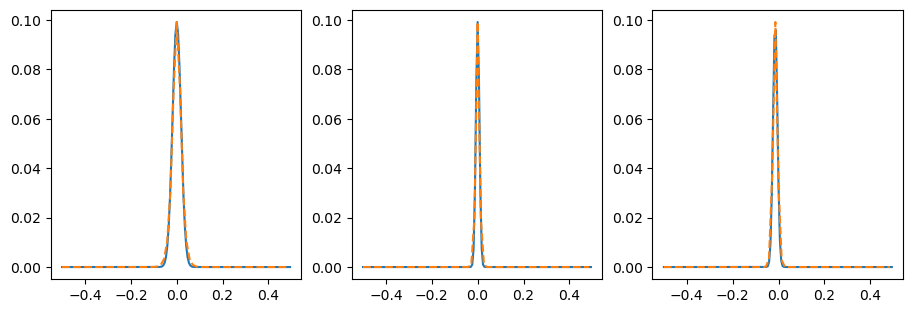

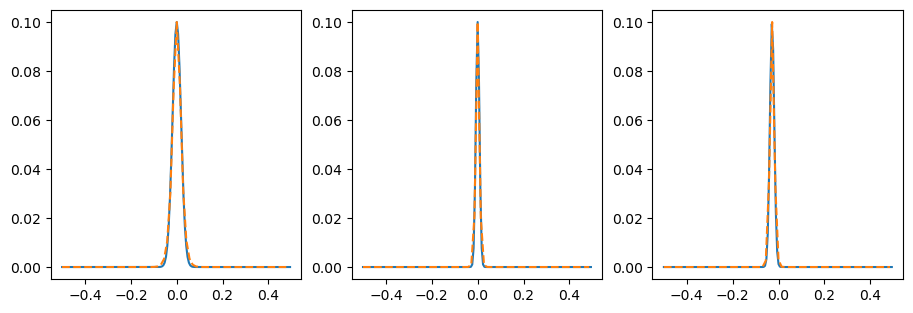

In [6]:
direccion = 'kx'

for ii_q in range(len(Q_plots)):
    if direccion == 'kx':
        d='x'
        QQ = np.array([Q_plots[ii_q],0.0,0.0])
    if direccion == 'ky':
        QQ = np.array([0.0,Q_plots[ii_q],0.0])
        d='y'
    if direccion == 'kz':
        QQ = np.array([0.0,0.0,Q_plots[ii_q]])
        d='z'
    
    if np.sign(Q_plots[ii_q]) <  0.0:
        path_excitons = "out_Hqpgw_minus_new_merlin"
    if np.sign(Q_plots[ii_q]) >  0.0:
        path_excitons = "out_Hqpgw_plus_new_merlin"
    if np.sign(Q_plots[ii_q]) == 0.0:
        path_excitons = "out_Hqpgw_new"
        
    ϵ_plus,ψ_plus = Incoherent.Reading_Data(QQ,path_excitons,retorno=5)
    pos_fix = np.where( np.reshape(ψ_plus[0,:], [nkx,nky,nkz]) ==np.max (np.reshape(ψ_plus[0,:], [nkx,nky,nkz])) )
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3.5))    

    exec('ax1.plot(x1_interp,ft(x1_interp,C{}[0,ii_q],Σ{}[0,ii_q],X0{}[0,ii_q],A{}[0,ii_q]))'.format(d,d,d,d) )
    ax1.plot(x1,np.reshape(ψ_plus[0,:], [nkx,nky,nkz])[:,pos_fix[1][0],pos_fix[2][0]],"--")

    exec('ax2.plot(x1_interp,ft(x1_interp,C{}[1,ii_q],Σ{}[1,ii_q],X0{}[1,ii_q],A{}[1,ii_q]))'.format(d,d,d,d) )
    ax2.plot(x1,np.reshape(ψ_plus[0,:], [nkx,nky,nkz])[pos_fix[0][0],:,pos_fix[2][0]],"--")

    exec('ax3.plot(x1_interp,ft(x1_interp,C{}[2,ii_q],Σ{}[2,ii_q],X0{}[2,ii_q],Ay[2,ii_q]))'.format(d,d,d,d) )
    ax3.plot(x1,np.reshape(ψ_plus[0,:], [nkx,nky,nkz])[pos_fix[0][0],pos_fix[1][0],:],"--")

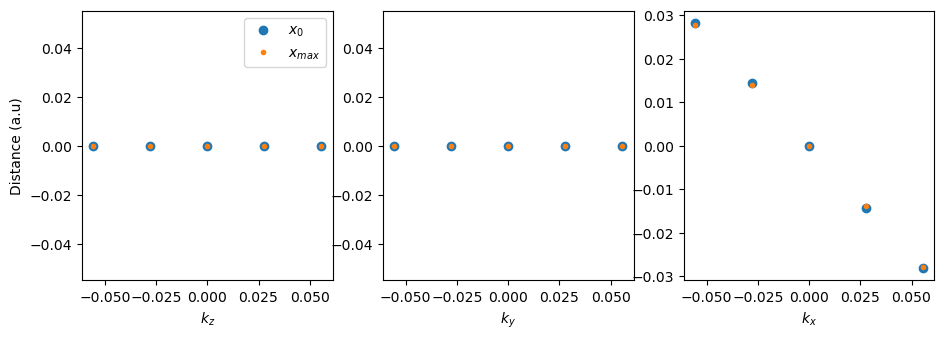

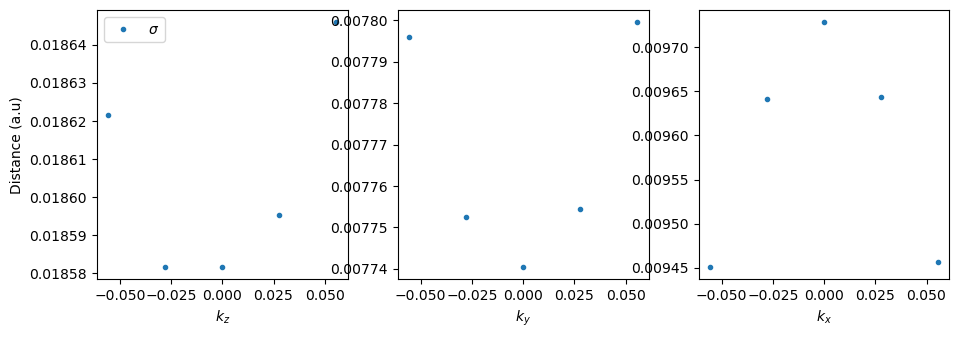

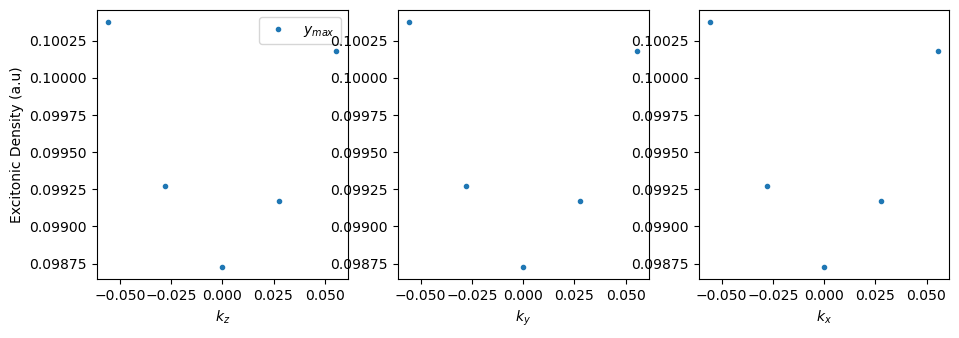

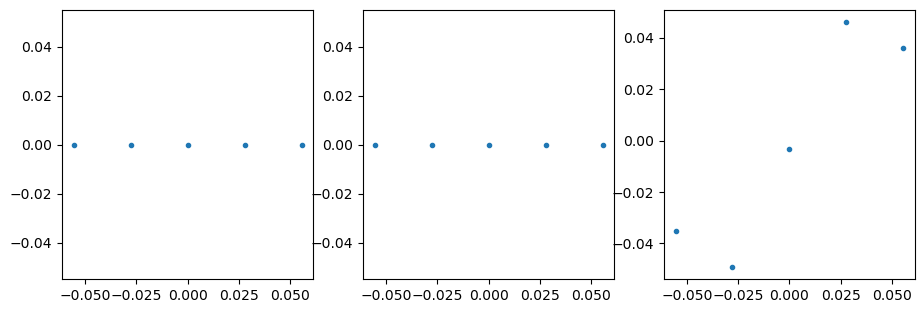

In [7]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3.5))
ax1.plot(Q_plots,X0x[0,:],'o',label=r'$x_0$')
ax1.plot(Q_plots,X_max_x[0,:],'.',label=r'$x_{max}$')
ax1.set_xlabel(r'$k_z$')
ax1.set_ylabel('Distance (a.u)')
ax1.legend()
ax2.plot(Q_plots,X0x[1,:],'o')
ax2.plot(Q_plots,X_max_x[1,:],'.')
ax2.set_xlabel(r'$k_y$')
ax3.plot(Q_plots,X0x[2,:],'o')
ax3.plot(Q_plots,X_max_x[2,:],'.')
ax3.set_xlabel(r'$k_x$')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3.5))
ax1.plot(Q_plots,Σx[0,:],'.',label=r'$\sigma$')
ax1.set_xlabel(r'$k_z$')
ax1.set_ylabel('Distance (a.u)')
ax1.legend()
ax2.plot(Q_plots,Σx[1,:],'.')
ax2.set_xlabel(r'$k_y$')
ax3.plot(Q_plots,Σx[2,:],'.')
ax3.set_xlabel(r'$k_x$')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3.5))
ax1.plot(Q_plots,Y_max_x[0,:],'.',label=r'$y_{max}$')
ax1.set_xlabel(r'$k_z$')
ax1.set_ylabel('Excitonic Density (a.u)')
ax1.legend()
ax2.plot(Q_plots,Y_max_x[1,:],'.')
ax2.set_xlabel(r'$k_y$')
ax3.plot(Q_plots,Y_max_x[2,:],'.')
ax3.set_xlabel(r'$k_x$')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3.5))
ax1.plot(Q_plots,Ax[0,:],'.')
#ax1.plot(Q_plots,Cy[0,:],'.')
ax2.plot(Q_plots,Ax[1,:],'.')
#ax2.plot(Q_plots,Cy[1,:],'.')
ax3.plot(Q_plots,Ax[2,:],'.')
#ax3.plot(Q_plots,Cy[2,:],'.')


"""#==========================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3.5))
ax1.plot(Q_plots,Ay[0,:],'.')
ax2.plot(Q_plots,Ay[1,:],'.')
ax3.plot(Q_plots,Ay[2,:],'.')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3.5))
ax1.plot(Q_plots,Cy[0,:],'.')
ax2.plot(Q_plots,Cy[1,:],'.')
ax3.plot(Q_plots,Cy[2,:],'.')""";



In [8]:
def inter(Q_interp,Q_plots,data):
    #return spline(Q_plots, data[0,:])(Q_interp), spline(Q_plots, data[1,:])(Q_interp), spline(Q_plots, data[2,:])(Q_interp)
    return interpolate.interp1d(Q_plots, data[0,:],fill_value="extrapolate")(Q_interp), interpolate.interp1d(Q_plots, data[1,:],fill_value="extrapolate")(Q_interp), interpolate.interp1d(Q_plots, data[2,:],fill_value="extrapolate")(Q_interp)
    
def AA_CC(X0x,X_max_x,Σx,Y_max_x,X0y,X_max_y,Σy,Y_max_y,X0z,X_max_z,Σz,Y_max_z):
    Ax = ( -X0x  + X_max_x) / ( X0x * X_max_x - X_max_x**2 +  Σx )
    Ay = ( -X0y  + X_max_y) / ( X0y * X_max_y - X_max_y**2 +  Σy )        
    Az = ( -X0z  + X_max_z) / ( X0z * X_max_z - X_max_z**2 +  Σz )        
    Cx =  Y_max_x/( ( 1+Ax * X_max_x ) * np.exp( -(X_max_x - X0x )**2/(2*Σx**2) ) )
    Cy =  Y_max_y/( ( 1+Ay * X_max_y ) * np.exp( -(X_max_y - X0y )**2/(2*Σy**2) ) )
    Cz =  Y_max_z/( ( 1+Az * X_max_z ) * np.exp( -(X_max_z - X0z )**2/(2*Σz**2) ) )
    
    return Ax,Ay,Az,Cx,Cy,Cz

def parameters(x1,QQ,Q_plots,X_max_x,Y_max_x,X0x,Σx,X_max_y,Y_max_y,X0y,Σy,X_max_z,Y_max_z,X0z,Σz,ϵ_x,ϵ_y,ϵ_z):
    X, Y, Z = np.meshgrid(x1, x1, x1, indexing='ij')

    Xmax_xi,Xmax_xj,Xmax_xk       = inter(QQ[0],Q_plots,X_max_x)
    Ymax_xi,Ymax_xj,Ymax_xk       = inter(QQ[0],Q_plots,Y_max_x)
    X0_xi,X0_xj,X0_xk             = inter(QQ[0],Q_plots,X0x)
    Σ_xi,Σ_xj,Σ_xk                = inter(QQ[0],Q_plots,Σx)
    A_xi,A_xj,A_xk,C_xi,C_xj,C_xk = AA_CC(X0_xi,Xmax_xi,Σ_xi,Ymax_xi,X0_xj,Xmax_xj,Σ_xj,Ymax_xj,X0_xk,Xmax_xk,Σ_xk,Ymax_xk)

    Xmax_yi,Xmax_yj,Xmax_yk       = inter(QQ[1],Q_plots,X_max_y)
    Ymax_yi,Ymax_yj,Ymax_yk       = inter(QQ[1],Q_plots,Y_max_y)
    X0_yi,X0_yj,X0_yk             = inter(QQ[1],Q_plots,X0y)
    Σ_yi,Σ_yj,Σ_yk                = inter(QQ[1],Q_plots,Σy)
    A_yi,A_yj,A_yk,C_yi,C_yj,C_yk = AA_CC(X0_yi,Xmax_yi,Σ_yi,Ymax_yi,X0_yj,Xmax_yj,Σ_yj,Ymax_yj,X0_yk,Xmax_yk,Σ_yk,Ymax_yk)

    Xmax_zi,Xmax_zj,Xmax_zk       = inter(QQ[2],Q_plots,X_max_z)
    Ymax_zi,Ymax_zj,Ymax_zk       = inter(QQ[2],Q_plots,Y_max_z)
    X0_zi,X0_zj,X0_zk             = inter(QQ[2],Q_plots,X0z)
    Σ_zi,Σ_zj,Σ_zk                = inter(QQ[2],Q_plots,Σz)
    A_zi,A_zj,A_zk,C_zi,C_zj,C_zk = AA_CC(X0_zi,Xmax_zi,Σ_zi,Ymax_zi,X0_zj,Xmax_zj,Σ_zj,Ymax_zj,X0_zk,Xmax_zk,Σ_zk,Ymax_zk)


    ρ_total =  C_xk*( 1+ A_xk*Z) * ( 1+ A_yj*Y) * ( 1+ A_zi*X) \
        *np.exp( -(Z-X0_xk)**2/(2*Σ_xk**2) )*np.exp( -(Y-X0_yj)**2/(2*Σ_yj**2) )*np.exp( -(X-X0_zi)**2/(2*Σ_zi**2) )
    
    ϵ_parameters = energy_interp(Q_plots,ϵ_x,ϵ_y,ϵ_z)
    
    ϵ_total = ϵ_parameters[0] + ϵ_parameters[1]*QQ[0]**2 + ϵ_parameters[2]*QQ[1]**2 + ϵ_parameters[3]*QQ[2]**2
    
    return ρ_total,ϵ_total

def func_bands_q(x, a, c, x0):
    return  a *(x-x0)**2 + c

def energy_interp(Q_plots,ϵ_x,ϵ_y,ϵ_z):
    poptx, pcovx = curve_fit( func_bands_q,Q_plots,ϵ_x )
    popty, pcovy = curve_fit( func_bands_q,Q_plots,ϵ_y )
    poptz, pcovz = curve_fit( func_bands_q,Q_plots,ϵ_z )
    return poptx[1],poptx[0],popty[0],poptz[0]

Q_interp_x = 0.0
Q_interp_y = 0.0556
Q_interp_z = 0.0556*0

QQ = np.array([Q_interp_x,Q_interp_y,Q_interp_z])

ρ_total,ϵ_total = parameters(x1_interp,QQ,Q_plots,X_max_x,Y_max_x,X0x,Σx,X_max_y,Y_max_y,X0y,Σy,X_max_z,Y_max_z,X0z,Σz,ϵ_x,ϵ_y,ϵ_z)
print(ϵ_total)

0.0199348438823859


(array([36]), array([36]), array([34])) (array([85]), array([80]), array([85]))


(-0.1, 0.1)

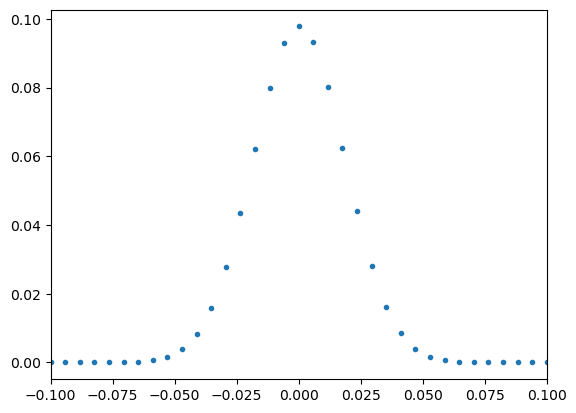

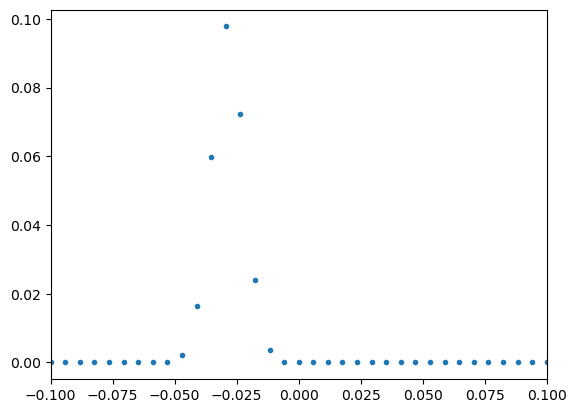

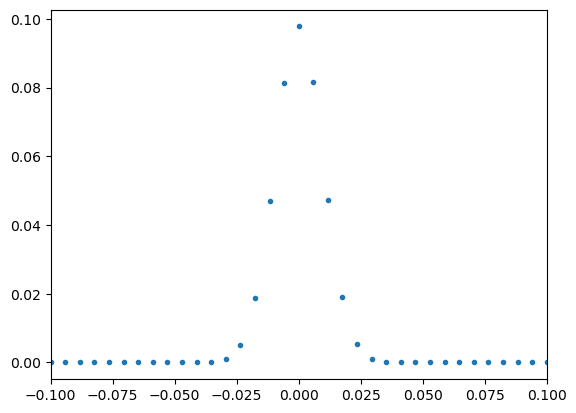

In [9]:
"""direccion = 'ky'

if direccion == 'kx':
    d='x'
    QQ = np.array([Q_interp,0.0,0.0])
if direccion == 'ky':
    QQ = np.array([0.0,Q_interp,0.0])
    d='y'
if direccion == 'kz':
    QQ = np.array([0.0,0.0,Q_interp])
    d='z'
"""
#Q_interp = 0.0278
#QQ = np.array([Q_interp,Q_interp,0.0])

#path_excitons ="out_Hqpgw_new"
#path_excitons = "out_Hqpgw_plus_new_merlin"
#path_excitons = "out_Hqpgw_minus_new_merlin"
#path_excitons = "out_Hqpgw_new_mixed_momenta"
        
#ϵ_plus,ψ_plus = Incoherent.Reading_Data(QQ,path_excitons,retorno=5)
#pos_fix = np.where( np.reshape(ψ_plus[0,:], [nkx,nky,nkz]) ==np.max (np.reshape(ψ_plus[0,:], [nkx,nky,nkz])) )
pos_fix_new = np.where( np.reshape(ρ_total, [nk_interp,nk_interp,nk_interp]) ==np.max (np.reshape(ρ_total, [nk_interp,nk_interp,nk_interp])) )
print(pos_fix,pos_fix_new)
plt.figure()
#plt.plot(x1,np.reshape(ψ_plus[0,:] , [nkx,nky,nkz])[:,pos_fix[1][0],pos_fix[2][0]])
plt.plot(x1_interp,np.reshape(ρ_total , [nk_interp,nk_interp,nk_interp])[:,pos_fix_new[1][0],pos_fix_new[2][0]],'.')
plt.xlim(-0.1,0.1)
plt.figure()
#plt.plot(x1,np.reshape(ψ_plus[0,:], [nkx,nky,nkz])[pos_fix[0][0],:,pos_fix[2][0]])
plt.plot(x1_interp,np.reshape(ρ_total, [nk_interp,nk_interp,nk_interp])[pos_fix_new[0][0],:,pos_fix_new[2][0]],".")
plt.xlim(-0.1,0.1)
plt.figure()
#plt.plot(x1,np.reshape(ψ_plus[0,:], [nkx,nky,nkz])[pos_fix[0][0],pos_fix[1][0],:])
plt.plot(x1_interp,np.reshape(ρ_total, [nk_interp,nk_interp,nk_interp])[pos_fix_new[0][0],pos_fix_new[1][0],:],".")
plt.xlim(-0.1,0.1)

In [10]:
#Ψ_k_p   = Photo.SHIFTING_KplusP(nuevok,nuevok,nuevok,yp,p_ex)
Ec_k_0  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Conduction,[0.0,0.0,0.0])
Ev_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,QQ)
Ev_k_0  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,[0.0,0.0,0.0])
Env_k_0 = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_no_Valence,[0.0,0.0,0.0])

EnergySpectrum = np.linspace(np.min(Energie_Valence)+ϵ_total-0.01,np.max(Energie_Valence)+ ϵ_total+0.015,800)

tolerancia = 0.0003
np.where(np.reshape(Ev_k_p, [nkx,nky,nkz]) == np.max( np.reshape(Ev_k_p, [nkx,nky,nkz]) )  )
#np.where(np.reshape(Ev_k_0, [nkx,nky,nkz]) == np.max( np.reshape(Ev_k_0, [nkx,nky,nkz]) )  )


(array([36]), array([32]), array([36]))

In [50]:
delta = 0.3
#k_points_path_k = np.array([[0.0,0.0,-delta],[0.0,0.0,delta]])
#k_points_path_Q = np.array([[-Q_interp_x,-Q_interp_y,-delta],[-Q_interp_x,-Q_interp_y,delta]])
k_points_path_k = np.array([[0.0,-delta,0.0],[0.0,delta,0.0]])
k_points_path_Q = np.array([[-Q_interp_x,-delta,-Q_interp_z],[-Q_interp_x,delta,-Q_interp_z]])
#k_points_path_k = np.array([[0.0,0.0,-delta],[0.0,0.0,delta]])
#k_points_path_Q = np.array([[-Q_interp_x,-Q_interp_y,-delta],[-Q_interp_x,-Q_interp_y,delta]])

n_kpts=270
x_kpts = np.linspace(0-delta,0+delta,n_kpts)
new_path_k = kgrid.K_PATH(k_points_path_k,n_kpts)
new_path_Q = kgrid.K_PATH(k_points_path_Q,n_kpts)
#print()
#Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,new_path)
Ψ_kpts   = Photo.FourierInterpolate(nk_interp,nk_interp,nk_interp,ρ_total,new_path_Q)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_0,new_path_k)
Ev_Qpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path_Q)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_0,new_path_k)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_0,new_path_k)

print(np.max(Ev_kpts)-np.max(Ev_Qpts))
Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1],2))
print((-np.max(Ev_Qpts)- ϵ_total)*27.2)
for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        Intensity_E[ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts[kk]- ϵ_total, tolerancia) * abs(Ψ_kpts[kk])*Incoherent.partition_weight(ϵ_total,1*cst.Ry)
        Intensity_E[ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])


-1.6632932177722964e-05
-0.171474658696901


In [209]:
print(np.max(Ev_kpts)*27.2-np.min(Ec_kpts)*27.2,ϵ_total*27.2)

-0.5062111888334493 0.5491925359802925


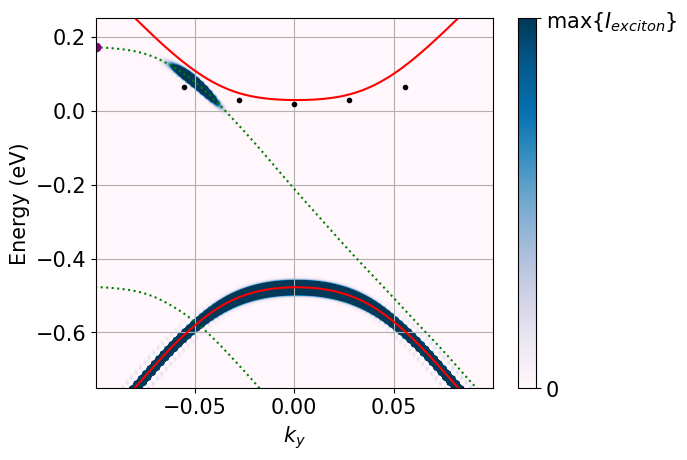

In [51]:
IntensityE_plot  = Intensity_E[:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
IntensityV_plot  = Intensity_E[:,:,1].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
Intensity = IntensityE_plot*10 + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'PuBu')

cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)

ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y),'.',color='black' )
ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='green')
ax1.plot(-Q_interp_y, cst.Ry *(np.max(Ev_Qpts) + ϵ_total),'o',color='purple')
ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='green')
ax1.plot(x_kpts, cst.Ry *Ev_kpts,'-',color='red')
ax1.plot(x_kpts, cst.Ry *Ec_kpts,'-',color='red')
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-.1,0.1)
ax1.set_xlabel(r"$k_y$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.set_xticks([-0.05,0.0,0.05])
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

plt.grid()

#plt.savefig("Incoherent_px0.00_py0.0556_pz0.00_direccion=y.png")
#plt.plot(x_kpts,Env_kpts,color='red')
"""plt.plot(x_kpts,Ev_Qpts,':',color='red')
plt.plot(x_kpts,Ev_kpts,color='black')
plt.axhline(y=np.max(Ev_kpts),ls='--')
""";

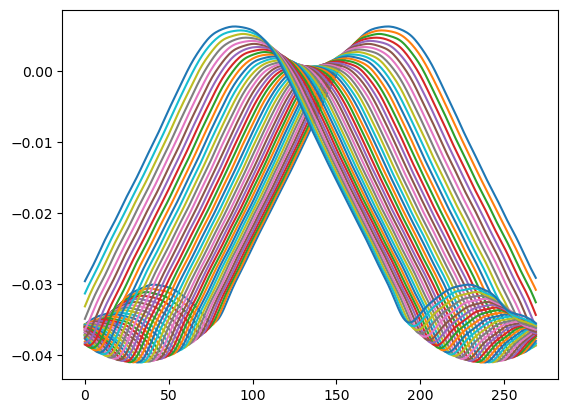

In [52]:
Q_grid=np.linspace(-0.1,0.1,40+1)
Intensity_E  = np.zeros((len(Q_grid),len(EnergySpectrum),np.shape(Ψ_kpts)[-1],2))


for qq_ii in range(len(Q_grid)):

    Q_interp_x = 0.0
    Q_interp_y = Q_grid[qq_ii]
    Q_interp_z = 0.0


    QQ = np.array([Q_interp_x,Q_interp_y,Q_interp_z])

    ρ_total,ϵ_total = parameters(x1_interp,QQ,Q_plots,X_max_x,Y_max_x,X0x,Σx,X_max_y,Y_max_y,X0y,Σy,X_max_z,Y_max_z,X0z,Σz,ϵ_x,ϵ_y,ϵ_z)
    ρ_total_0,ϵ_total_0 = parameters(x1_interp,[0.0,0.0,0.0],Q_plots,X_max_x,Y_max_x,X0x,Σx,X_max_y,Y_max_y,X0y,Σy,X_max_z,Y_max_z,X0z,Σz,ϵ_x,ϵ_y,ϵ_z)
    #plt.figure()
    #plt.plot(x1_interp,np.reshape(ρ_total, [nk_interp,nk_interp,nk_interp])[pos_fix_new[0][0],:,pos_fix_new[2][0]],".")
    #plt.xlim(-0.1,0.1)
    
    Ec_k_0  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Conduction,[0.0,0.0,0.0])
    Ev_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,QQ)
    Ev_k_0  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,[0.0,0.0,0.0])
    Env_k_0 = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_no_Valence,[0.0,0.0,0.0])

    EnergySpectrum = np.linspace(np.min(Energie_Valence)-0.01,np.max(Energie_Valence)+0.04,800)

    tolerancia = 0.0003
    delta = 0.3
    k_points_path_k = np.array([[0.0,-delta,0.0],[0.0,delta,0.0]])
    k_points_path_Q = np.array([[-Q_interp_x,-delta,-Q_interp_z],[-Q_interp_x,delta,-Q_interp_z]])
    #k_points_path_k = np.array([[0.0,0.0,-delta],[0.0,0.0,delta]])
    #k_points_path_Q = np.array([[-Q_interp_x,-Q_interp_y,-delta],[-Q_interp_x,-Q_interp_y,delta]])
    
    n_kpts=270
    x_kpts = np.linspace(0-delta,0+delta,n_kpts)
    
    new_path_k = kgrid.K_PATH(k_points_path_k,n_kpts)
    new_path_Q = kgrid.K_PATH(k_points_path_Q,n_kpts)

    Ψ_kpts   = Photo.FourierInterpolate(nk_interp,nk_interp,nk_interp,ρ_total,new_path_Q)
    Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_0,new_path_k)
    Ev_Qpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path_Q)
    Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_0,new_path_k)
    Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_0,new_path_k)

    plt.plot(Ev_Qpts+ϵ_total)

    for ω_ii in range(len(EnergySpectrum)):

        for kk in range(np.shape(Ev_kpts)[-1]):
            Intensity_E[qq_ii,ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts[kk]- ϵ_total, tolerancia) * abs(Ψ_kpts[kk])*Incoherent.partition_weight(ϵ_total,10*cst.Ry)/Incoherent.partition_weight(ϵ_total_0,10*cst.Ry)
            Intensity_E[qq_ii,ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])

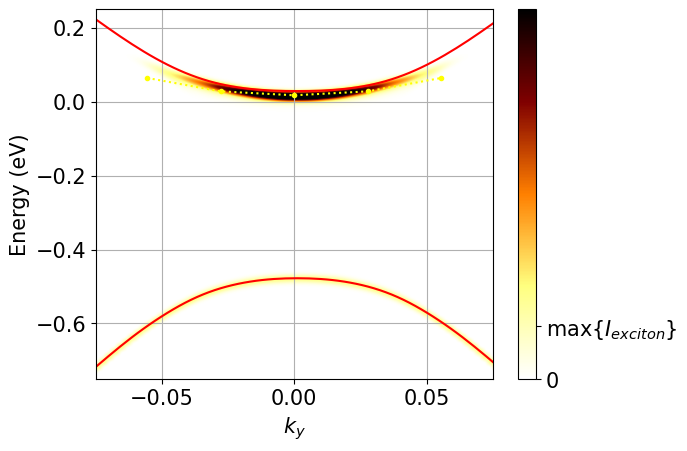

In [63]:
#IntensityE_plot0  = Intensity_E[0,:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
#IntensityE_plot1  = Intensity_E[1,:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]

IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
for qq_ii in range(len(Q_grid)):
    IntensityE_plot += Intensity_E[qq_ii,:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]

IntensityV_plot  = Intensity_E[0,:,:,1].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
Intensity = IntensityE_plot*10 + IntensityV_plot

fig, ax1 = plt.subplots()

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=7*np.max(np.abs(IntensityE_plot)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
            #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'twilight_r')
           origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)


ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y),'.:',color='yellow' )
#ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
#ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')
ax1.plot(x_kpts, cst.Ry *Ev_kpts,'-',color='red')
ax1.plot(x_kpts, cst.Ry *Ec_kpts,'-',color='red')
ax1.set_ylim(-.75,0.25)
ax1.set_xlim(-.075,0.075)
ax1.set_xlabel(r"$k_y$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.set_xticks([-0.05,0.0,0.05])
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
plt.grid()

In [ ]:
# delta = 0.1
k_points_path = np.array([[0.0,-delta,0.0],[0.0,delta,0.0]])
n_kpts=140
x_kpts = np.linspace(0-delta,0+delta,n_kpts)
new_path = kgrid.K_PATH(k_points_path,n_kpts)

#Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,new_path)
Ψ_kpts   = Photo.FourierInterpolate(nk_interp,nk_interp,nk_interp,ρ_total,new_path)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,new_path)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,new_path)


(-0.03, 0.01)

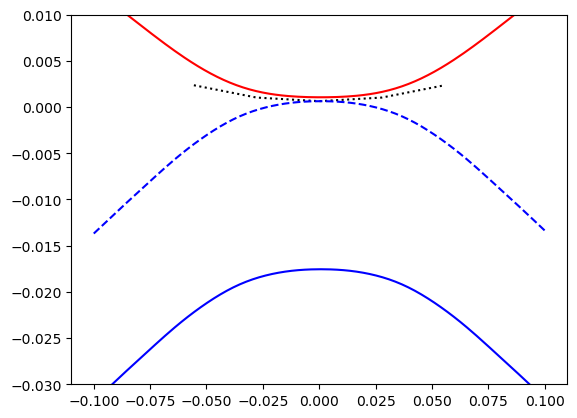

In [101]:
plt.plot(x_kpts,Ev_kpts,color='blue')
plt.plot(Q_plots,np.max(Ev_kpts) + ϵ_y,':',color='black' )
plt.plot(x_kpts,Ev_kpts + ϵ_total,'--',color='blue')
plt.plot(x_kpts,Ec_kpts,color='red')
#plt.xlim(-0.05,0.05)
plt.ylim(-0.03,0.01)

In [32]:
Q_grid=np.linspace(-0.3,0.3,60+1)

particion = np.zeros_like(Q_grid)
energias  =  np.zeros_like(Q_grid)

for qq_ii in range(len(Q_grid)):

    Q_interp_x = 0.0
    Q_interp_y = Q_grid[qq_ii]
    Q_interp_z = 0.0


    QQ = np.array([Q_interp_x,Q_interp_y,Q_interp_z])
    ρ_total,ϵ_total = parameters(x1_interp,QQ,Q_plots,X_max_x,Y_max_x,X0x,Σx,X_max_y,Y_max_y,X0y,Σy,X_max_z,Y_max_z,X0z,Σz,ϵ_x,ϵ_y,ϵ_z)
    ρ_total_0,ϵ_total_0 = parameters(x1_interp,[0.0,0.0,0.0],Q_plots,X_max_x,Y_max_x,X0x,Σx,X_max_y,Y_max_y,X0y,Σy,X_max_z,Y_max_z,X0z,Σz,ϵ_x,ϵ_y,ϵ_z)
    particion[qq_ii] = Incoherent.partition_weight(ϵ_total,100*cst.Ry)/Incoherent.partition_weight(ϵ_total_0,100*cst.Ry)
    energias[qq_ii] = ϵ_total

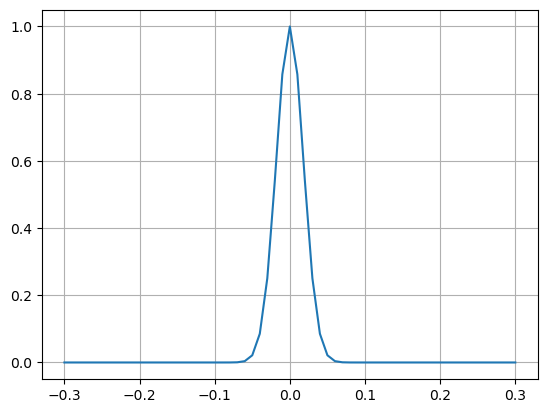

In [33]:
plt.plot(Q_grid,particion)
plt.grid()

In [48]:
200000/cst.Ry

7349.864501572981